# THIS PROGRAM USES EXPLORATORY DATA ANALYSIS AND REGRESSION TO PREDICT THE WINNER OF THE FIFA WORLD CUP 2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
random_no = 122
from sklearn import preprocessing
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import random
%matplotlib inline

In [2]:
df = pd.read_csv('results.csv')

In [3]:
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [4]:
#Describing the dataset
df.describe()

,home_score,away_score
count,42428.000000,42428.000000
mean,1.744131,1.185703
std,1.753119,1.404194
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,31.000000,21.000000


In [5]:
#Finding missing values
df.isnull().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

([<matplotlib.axis.XTick at 0x7ff2f64adac0>,
 [Text(1, 0, 'Home Score'), Text(2, 0, 'Away Score')])

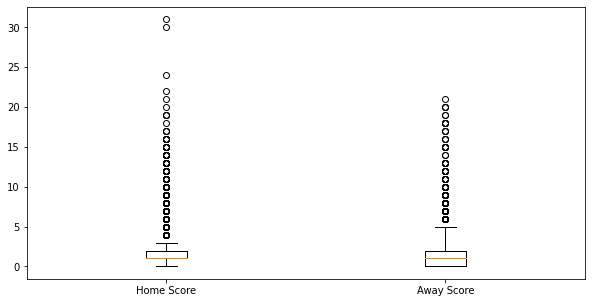

In [6]:
#Finding outliers in the numerical columns of df
fig = plt.figure(figsize =(10, 5))
plt.boxplot([df["home_score"],df["away_score"]])
plt.xticks([1,2], ["Home Score", "Away Score"])

## The box plot suggests there are many outliers. We'll remove them to increase the accuracy of our model

In [7]:
#Assuming the maximum goals a team can score to be 10

high_home = 10
high_away = 10
df = df[(df["home_score"] < high_home) & (df["away_score"] < high_away)]
df.head(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False
5,1876-03-25,Scotland,Wales,4,0,Friendly,Glasgow,Scotland,False
6,1877-03-03,England,Scotland,1,3,Friendly,London,England,False
7,1877-03-05,Wales,Scotland,0,2,Friendly,Wrexham,Wales,False
8,1878-03-02,Scotland,England,7,2,Friendly,Glasgow,Scotland,False
9,1878-03-23,Scotland,Wales,9,0,Friendly,Glasgow,Scotland,False


In [8]:
#Now, we make a new column "Win_Status" to store the result(Win,Lost,Draw) of the home team

conditions  = [df["home_score"] == df["away_score"], df["home_score"] > df["away_score"] , df["home_score"] < df["away_score"]]
choices     = [ "Draw", 'Win', 'Lost' ]
df["Win_Status"] = np.select(conditions, choices)
df.head(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Win_Status
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,Draw
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,Win
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,Win
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,Draw
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,Win
5,1876-03-25,Scotland,Wales,4,0,Friendly,Glasgow,Scotland,False,Win
6,1877-03-03,England,Scotland,1,3,Friendly,London,England,False,Lost
7,1877-03-05,Wales,Scotland,0,2,Friendly,Wrexham,Wales,False,Lost
8,1878-03-02,Scotland,England,7,2,Friendly,Glasgow,Scotland,False,Win
9,1878-03-23,Scotland,Wales,9,0,Friendly,Glasgow,Scotland,False,Win


In [9]:
# What countries are in the dataset

n_countries = df.home_team.unique()
print(f"There are {len(n_countries)} Countries in the home_team Column\n")
print(f"Countries : {n_countries}")

There are 304 Countries in the home_team Column

Countries : ['Scotland' 'England' 'Wales' 'Northern Ireland' 'United States' 'Uruguay'
 'Austria' 'Hungary' 'Argentina' 'Belgium' 'France' 'Netherlands'
 'Czechoslovakia' 'Switzerland' 'Germany' 'Italy' 'Chile' 'Norway'
 'Sweden' 'Finland' 'Luxembourg' 'Russia' 'Denmark' 'Catalonia'
 'Basque Country' 'Brazil' 'Paraguay' 'Japan' 'Canada' 'Estonia'
 'Costa Rica' 'Guatemala' 'Spain' 'Brittany' 'Poland' 'Yugoslavia'
 'New Zealand' 'Romania' 'Latvia' 'Galicia' 'Portugal' 'Andalusia'
 'China PR' 'Australia' 'Lithuania' 'Turkey' 'Central Spain' 'Mexico'
 'Aruba' 'Haiti' 'Philippines' 'Bulgaria' 'Jamaica' 'Kenya' 'Bolivia'
 'Peru' 'Honduras' 'Guyana' 'Uganda' 'Belarus' 'El Salvador' 'Barbados'
 'Republic of Ireland' 'Trinidad and Tobago' 'Greece' 'Curaçao' 'Egypt'
 'Dominica' 'Silesia' 'Guadeloupe' 'Israel' 'Suriname' 'French Guiana'
 'Cuba' 'Colombia' 'Ecuador' 'Saint Kitts and Nevis' 'Panama' 'Slovakia'
 'Manchukuo' 'Croatia' 'Nicaragua' 'Afgh

## Next we see the type of matches

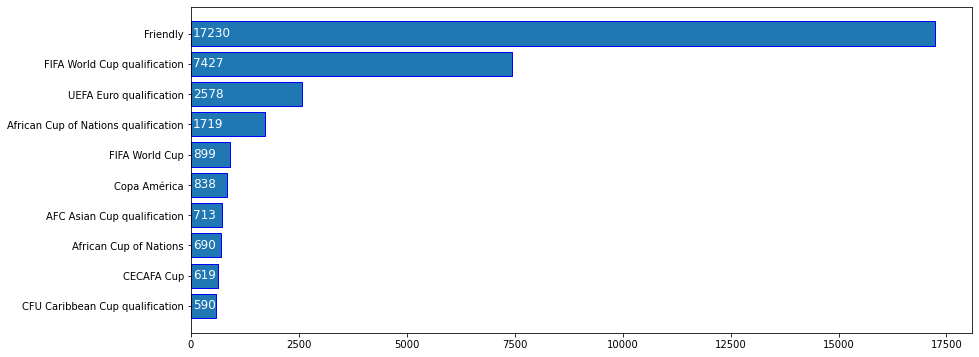

Most type of match played is: Friendly
Least type of match played is: CFU Caribbean Cup qualification


In [10]:
rank_bound = 10
ax = df.tournament.value_counts()[:rank_bound].sort_values()
value = ax.values
label = ax.index

plt.figure(figsize=(14,6))
plt.barh(y=label, width=value, edgecolor="b")
for i in range(rank_bound):
    plt.text(x=50,y=i-0.1,s=value[i],color="w",fontsize=12)
plt.show()
print(f'Most type of match played is: {label[-1]}')
print(f'Least type of match played is: {label[0]}')

## The team that's played the highest number of matches

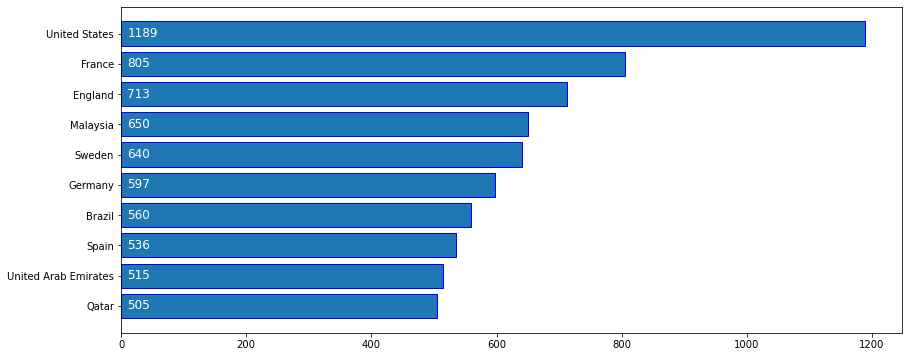

United States has played the highest number of matches
Qatar has played the least number of matches


In [11]:
rank_bound = 10
ax = df.country.value_counts()[:rank_bound].sort_values()
value = ax.values
label = ax.index

plt.figure(figsize=(14,6))
plt.barh(y=label, width=value, edgecolor="b")
for i in range(rank_bound):
    plt.text(x=10,y=i-0.1,s=value[i],color="w",fontsize=12)
plt.show()
print(f'{label[-1]} has played the highest number of matches')
print(f'{label[0]} has played the least number of matches')

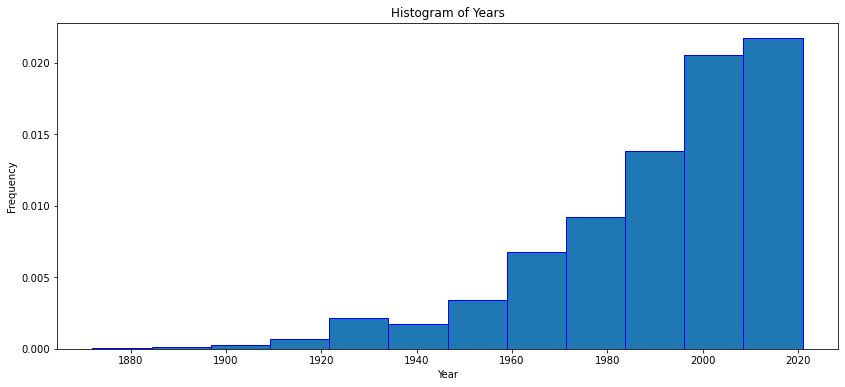

In [12]:
years = []
for date in df.date:
    years.append(int(str(date)[0:4]))
plt.figure(figsize=(14,6))
plt.hist(years, density=True, bins=12, edgecolor="b")
plt.title("Histogram of Years")
plt.ylabel("Frequency")
plt.xlabel("Year")
plt.show()
#Most matches are played after 1960

## Finding out the impact if a country hosts a tournament not including friendlies

In [13]:
data_home=df.loc[df["home_team"] == df["country"] ]
data_home=df.loc[df["tournament"] != "Friendly"]
data_home.head(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Win_Status
29,1884-01-26,Northern Ireland,Scotland,0,5,British Championship,Belfast,Republic of Ireland,False,Lost
30,1884-02-09,Wales,Northern Ireland,6,0,British Championship,Wrexham,Wales,False,Win
31,1884-02-23,Northern Ireland,England,1,8,British Championship,Belfast,Republic of Ireland,False,Lost
32,1884-03-15,Scotland,England,1,0,British Championship,Glasgow,Scotland,False,Win
33,1884-03-17,Wales,England,0,4,British Championship,Wrexham,Wales,False,Lost
34,1884-03-29,Scotland,Wales,4,1,British Championship,Glasgow,Scotland,False,Win
35,1885-02-28,England,Northern Ireland,4,0,British Championship,Manchester,England,False,Win
36,1885-03-14,England,Wales,1,1,British Championship,Blackburn,England,False,Draw
37,1885-03-14,Scotland,Northern Ireland,8,2,British Championship,Glasgow,Scotland,False,Win
38,1885-03-21,England,Scotland,1,1,British Championship,London,England,False,Draw


In [14]:
#How does a home team perform in tournament matches

tournament_df = pd.crosstab(data_home["tournament"], data_home["Win_Status"],margins=True)
tournament_df = tournament_df.sort_values("All",ascending=False).head(10)
tournament_df.style.bar(color="brown",subset=["Draw","Lost","Win","All"])

Win_Status,Draw,Lost,Win,All
tournament,,,,
All,5442,7153,12355,24950
FIFA World Cup qualification,1590,2025,3812,7427
UEFA Euro qualification,506,814,1258,2578
African Cup of Nations qualification,418,353,948,1719
FIFA World Cup,199,290,410,899
Copa América,181,231,426,838
AFC Asian Cup qualification,123,174,416,713
African Cup of Nations,193,186,311,690
CECAFA Cup,147,185,287,619


Text(0.5, 1.0, 'Home Team Winning Status')

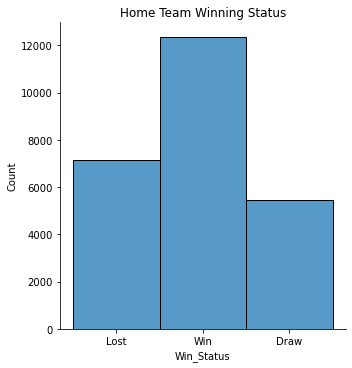

In [15]:
#Home team results
sns.displot(data = data_home, x = "Win_Status")
plt.title("Home Team Winning Status")

In [16]:
data_home['Win_Status'].value_counts()

Win     12355
Lost     7153
Draw     5442
Name: Win_Status, dtype: int64

In [17]:
#How each team perform while playing a tournament in home grounds

teams_win_status=pd.crosstab(df["home_team"], df["Win_Status"],margins=True, margins_name="Total")
teams_win_status["team_win_probability"] = teams_win_status["Win"]/(teams_win_status["Total"])
#We'll consider teams which play atleast 300 games
teams_win_status_100 = teams_win_status.loc[teams_win_status["Total"] > 300]
teams_win_status_100 = teams_win_status_100.sort_values("team_win_probability",ascending=False)
teams_win_status_100.head(25).style.bar(color = "cyan",subset = "team_win_probability")

#We can see teams have more than 50% wining probability while playing in the home grounds which indicates 
#that home ground make a real difference to the performance of the teams

Win_Status,Draw,Lost,Win,Total,team_win_probability
home_team,,,,,
Brazil,110,57,413,580,0.712069
Spain,69,49,248,366,0.677596
Argentina,123,68,364,555,0.655856
Italy,120,49,286,455,0.628571
Egypt,68,74,236,378,0.624339
England,111,82,319,512,0.623047
Germany,111,85,320,516,0.620155
Russia,70,49,185,304,0.608553
South Korea,112,79,279,470,0.593617


## Away team winning statistics

In [18]:
teams_away_status = pd.crosstab(df["away_team"], df["Win_Status"],margins = True, margins_name = "Total")
teams_away_status["team_win_probability"] = teams_away_status["Lost"]/(teams_away_status["Total"])
#We'll consider teams which play atleast 300 games
teams_away_status_100 = teams_away_status.loc[teams_away_status["Total"] > 300]
teams_away_status_100 = teams_away_status_100.sort_values("team_win_probability",ascending=False)
teams_away_status_100.rename(columns={'Lost': 'Win'}, index={'Win': 'Lost'}, inplace=True)
teams_away_status_100.head(20)

#The probability of winning a tournament in away conditions is very low compared to the
#winning probalities in home conditions

Win_Status,Draw,Win,Win,Total,team_win_probability
away_team,,,,,
Brazil,92,224,102,418,0.535885
Germany,89,240,119,448,0.535714
England,134,263,115,512,0.513672
Spain,99,163,82,344,0.473837
South Korea,110,178,109,397,0.448363
Netherlands,81,163,129,373,0.436997
Russia,116,174,112,402,0.432836
Italy,109,151,104,364,0.414835
Sweden,121,219,198,538,0.407063


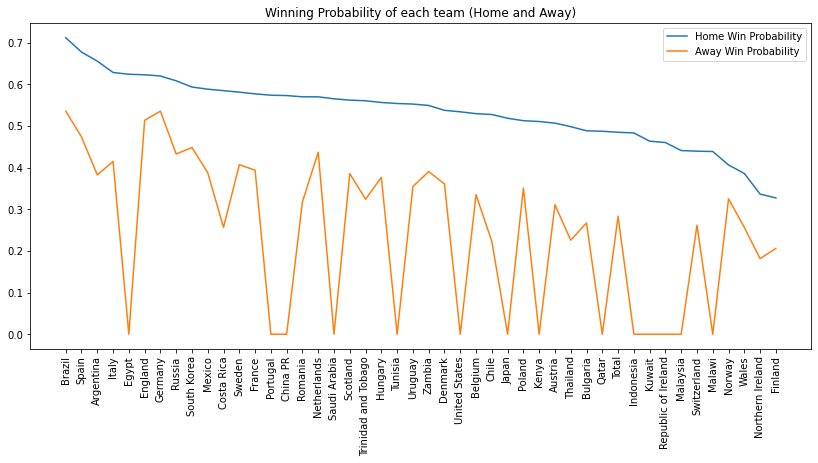

In [19]:
#Making a plot to identify wining possibilities in both home and away conditions

win_prob={teams_win_status_100.iloc[i,:].name:[teams_win_status_100.iloc[i,4]] for i in range(teams_win_status_100.shape[0])}
for i in range(teams_away_status_100.shape[0]):
    try:
        win_prob[teams_away_status_100.iloc[i,:].name].append(teams_away_status_100.iloc[i,4]) 
    except:
        pass
country_names=win_prob.keys()
lst_home=[i[0] for i in win_prob.values()]

lst_away=[]
for i in win_prob.values():
    if len(i)==2:
        lst_away.append(i[1])
    else:
        lst_away.append(0)
plt.figure(figsize=(14,6))
plt.plot(country_names,lst_home, label = "Home Win Probability")
plt.plot(country_names, lst_away, label = "Away Win Probability")
plt.xticks(rotation = 90)
plt.title("Winning Probability of each team (Home and Away)")
plt.legend()
plt.show()

## Blue line is above yellow line implying that winning at homes have high probabilities. Thus, by analyzing the data, we can identify that the home team has a clear edge while playing a tournament in their home grounds

## Next, we find the most successful team

In [20]:
#Home Conditions
#Convert the data set into 10 terms and find which team has done best at each term 

range_years = max(years)-min(years)
n_terms = 10
term_size = int(range_years/n_terms)
for i in range(n_terms+1):
    start = years.index(term_size*i + min(years))
    end = years.index(min(term_size*(i+1) + min(years),2021))
    term = df.iloc[start:end]
    best_team = pd.crosstab(term["home_team"], term["Win_Status"],margins=True, margins_name="Total")
    
    ##Lets take teams which plays atleast 30 games
    best_team["team_win_probability"] = best_team["Win"]/(best_team["Total"])
    best_team = best_team.sort_values("team_win_probability",ascending=False)
    best_team = best_team.loc[best_team["Total"] > 20]
    if (best_team.shape[0] > 2):
        print(f"\nBest 2 teams in the term: {term_size*i + min(years)} - {min(term_size*(i+1) + min(years),2021)} ")
        print(best_team.iloc[0:2].to_markdown())
    else:
        print(f"Not enough data to find the best team in the term: {term_size*i+min(years)} - {min(term_size*(i+1) + min(years),2021)} ")

Not enough data to find the best team in the term: 1872 - 1886 

Best 2 teams in the term: 1886 - 1900 
| home_team   |   Draw |   Lost |   Win |   Total |   team_win_probability |
|:------------|-------:|-------:|------:|--------:|-----------------------:|
| England     |      1 |      3 |    17 |      21 |               0.809524 |
| Scotland    |      3 |      3 |    16 |      22 |               0.727273 |

Best 2 teams in the term: 1900 - 1914 
| home_team   |   Draw |   Lost |   Win |   Total |   team_win_probability |
|:------------|-------:|-------:|------:|--------:|-----------------------:|
| England     |      6 |      1 |    14 |      21 |               0.666667 |
| Hungary     |      6 |      3 |    16 |      25 |               0.64     |

Best 2 teams in the term: 1914 - 1928 
| home_team   |   Draw |   Lost |   Win |   Total |   team_win_probability |
|:------------|-------:|-------:|------:|--------:|-----------------------:|
| Denmark     |      4 |      3 |    18 |     

## Making a Machine Learning model

In [21]:
df_match = df.copy() #making a copy of the main dataframe for future use
df_match.head(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Win_Status
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,Draw
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,Win
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,Win
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,Draw
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,Win
5,1876-03-25,Scotland,Wales,4,0,Friendly,Glasgow,Scotland,False,Win
6,1877-03-03,England,Scotland,1,3,Friendly,London,England,False,Lost
7,1877-03-05,Wales,Scotland,0,2,Friendly,Wrexham,Wales,False,Lost
8,1878-03-02,Scotland,England,7,2,Friendly,Glasgow,Scotland,False,Win
9,1878-03-23,Scotland,Wales,9,0,Friendly,Glasgow,Scotland,False,Win


In [22]:
#Next, we make a new dataset with required features to train the machine learning model
#The columns are : Year,Played Country,Team_1,team_2,team_1 score,team_2 score

df_new_1 = pd.DataFrame(list(zip(years,df_match.values[:,7],df_match.values[:,1],df_match.values[:,2],df_match.values[:,3],df_match.values[:,4])),columns=["year","Country","team_1","team_2","team_1_score","team_2_score"])
#Making a new dataset by changing the team_1 and team_2 and their respective scores
df_new_2 = pd.DataFrame(list(zip(years,df_match.values[:,7],df_match.values[:,2],df_match.values[:,1],df_match.values[:,4],df_match.values[:,3])),columns=["year","Country","team_1","team_2","team_1_score","team_2_score"])
df_new = pd.concat([df_new_1,df_new_2],axis=0)
df_new = df_new.sample(frac=1).reset_index(drop=True) #Shuffling the dataset
df_new.head(10)

,year,Country,team_1,team_2,team_1_score,team_2_score
0,1966,Panama,Panama,Guatemala,0,1
1,1973,Peru,Panama,Peru,0,4
2,1961,Paraguay,Paraguay,Brazil,2,3
3,2001,China PR,China PR,Indonesia,5,1
4,1978,Ghana,Nigeria,Ghana,1,1
5,1915,Austria,Austria,Hungary,1,2
6,1980,Panama,Panama,El Salvador,1,3
7,2006,Hong Kong,Croatia,Hong Kong,4,0
8,2020,Switzerland,Croatia,Switzerland,2,1
9,2011,United States,United States,Costa Rica,0,1


In [23]:
#Creating a list containg all the names of the countries

teams_1=df_new.team_1.unique()
contries=df_new.Country.unique()
all_countries=np.unique(np.concatenate((teams_1,contries), axis=0))
len(all_countries)

342

,year,team_1_score,team_2_score
year,1.000000,-0.129325,-0.129325
team_1_score,-0.129325,1.000000,-0.155582
team_2_score,-0.129325,-0.155582,1.000000


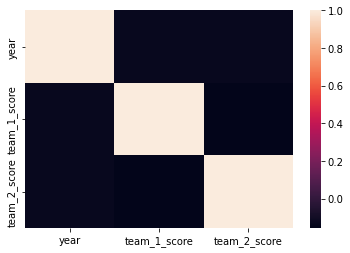

In [24]:
#Generating a heatmap to see the correlation of each columns 

sns.heatmap(df_new.corr())
df_new.corr()

## Data Preprocessing

In [25]:
#Defining the features and labels(Targets)

Y= df_new.iloc[:,4:6] #Training targets (team_1_score and team_2_score)
categorized_data=df_new.iloc[:,0:4].copy() #Traing features

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

#Labeling the data using LabelEncorder in Sklearn-(Giving a unique number to each string(country))

label_encoder.fit(all_countries)
#list(label_encoder.classes_)
categorized_data['team_1']=label_encoder.transform(categorized_data['team_1'])
categorized_data['team_2']=label_encoder.transform(categorized_data['team_2'])
categorized_data['Country']=label_encoder.transform(categorized_data['Country'])

#Converting these feature columns to categrize form to make the training processs more smoother
categorized_data['team_1']=categorized_data['team_1'].astype("category")
categorized_data['team_2']=categorized_data['team_2'].astype("category")
categorized_data['Country']=categorized_data['team_2'].astype("category")

In [26]:
#Features
categorized_data.head(10)

,year,Country,team_1,team_2
0,1966,122,223,122
1,1973,228,223,228
2,1961,39,226,39
3,2001,135,63,135
4,1978,112,206,112
5,1915,132,18,132
6,1980,88,223,88
7,2006,131,72,131
8,2020,284,72,284
9,2011,69,312,69


In [27]:
#Target
Y.head(10)

,team_1_score,team_2_score
0,0,1
1,0,4
2,2,3
3,5,1
4,1,1
5,1,2
6,1,3
7,4,0
8,2,1
9,0,1


In [28]:
print(categorized_data.info())
print(Y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84360 entries, 0 to 84359
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   year     84360 non-null  int64   
 1   Country  84360 non-null  category
 2   team_1   84360 non-null  category
 3   team_2   84360 non-null  category
dtypes: category(3), int64(1)
memory usage: 1.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84360 entries, 0 to 84359
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   team_1_score  84360 non-null  int64
 1   team_2_score  84360 non-null  int64
dtypes: int64(2)
memory usage: 1.3 MB
None


In [29]:
#Making the model

X = categorized_data
model = MultiOutputRegressor(RandomForestClassifier())
model.fit(X,Y)

MultiOutputRegressor(estimator=RandomForestClassifier())

In [30]:
prediction = model.predict(X)
prediction

array([[0, 1],
       [0, 4],
       [2, 3],
       ...,
       [2, 2],
       [2, 1],
       [2, 2]])

In [31]:
#Creating the Confusion matrix for each predictions

score_team_1=[i[0] for i in prediction]
score_team_2=[i[1] for i in prediction]

from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(list(Y.iloc[:,0]),score_team_1)
cm2 = confusion_matrix(list(Y.iloc[:,1]),score_team_2)

Text(159.0, 0.5, 'Predicted')

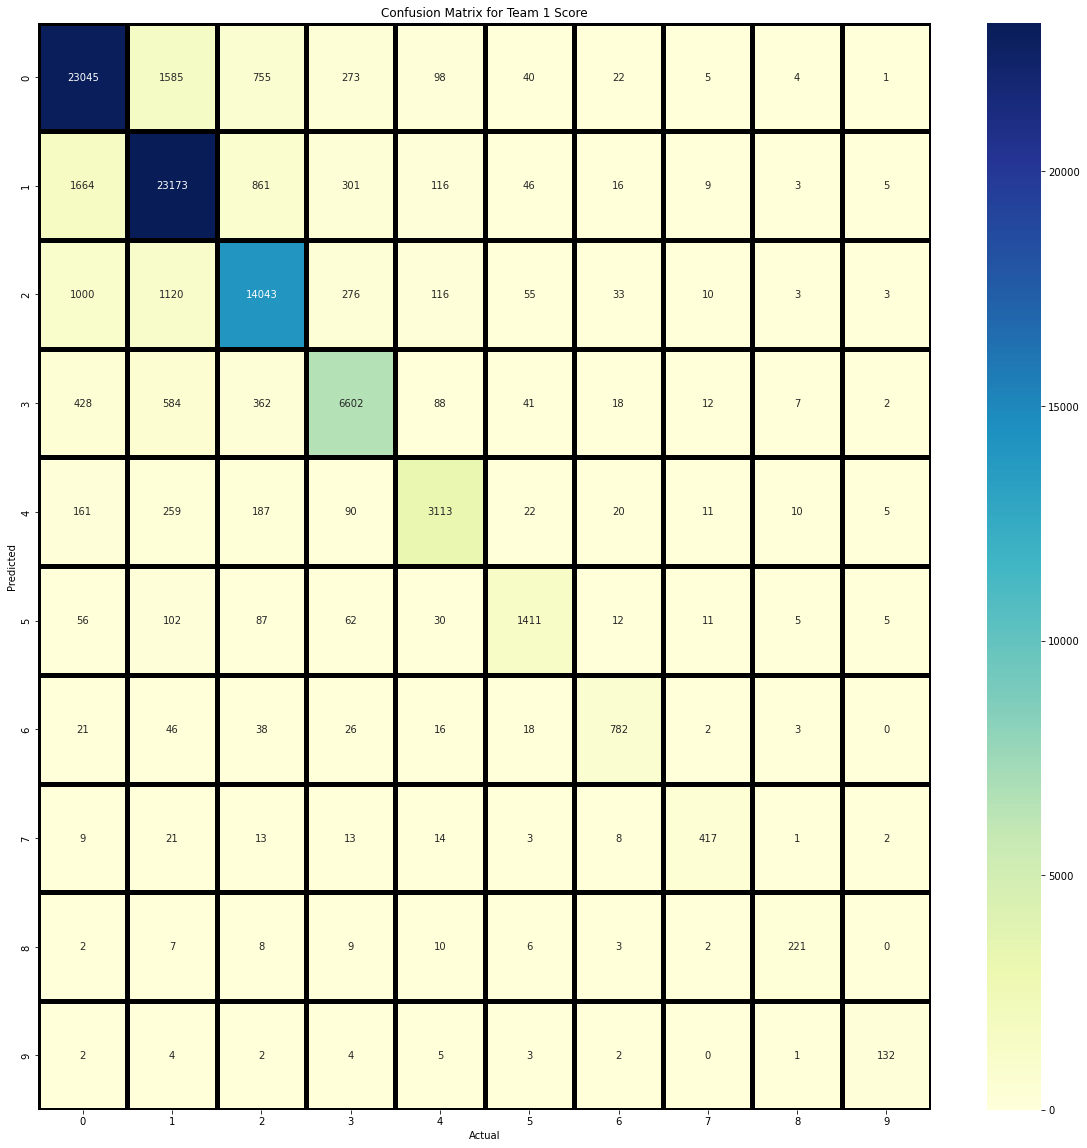

In [32]:
#Plotting the Confussion Matrix for score of Team 1

plt.figure(figsize = (20,20))
sns.heatmap(cm1, annot = True, fmt = "d", cmap = 'YlGnBu', linecolor = 'black', linewidths = 5)
plt.title("Confusion Matrix for Team 1 Score")
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [33]:
#Classification Report of team 1 Score

cr_report01 = classification_report(Y.iloc[:,0] , score_team_1)
print(cr_report01)

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     25828
           1       0.86      0.88      0.87     26194
           2       0.86      0.84      0.85     16659
           3       0.86      0.81      0.84      8144
           4       0.86      0.80      0.83      3878
           5       0.86      0.79      0.82      1781
           6       0.85      0.82      0.84       952
           7       0.87      0.83      0.85       501
           8       0.86      0.82      0.84       268
           9       0.85      0.85      0.85       155

    accuracy                           0.86     84360
   macro avg       0.86      0.84      0.85     84360
weighted avg       0.86      0.86      0.86     84360



## Report 01 has a good accuracy in predicting the team 1 Score

Text(159.0, 0.5, 'Predicted')

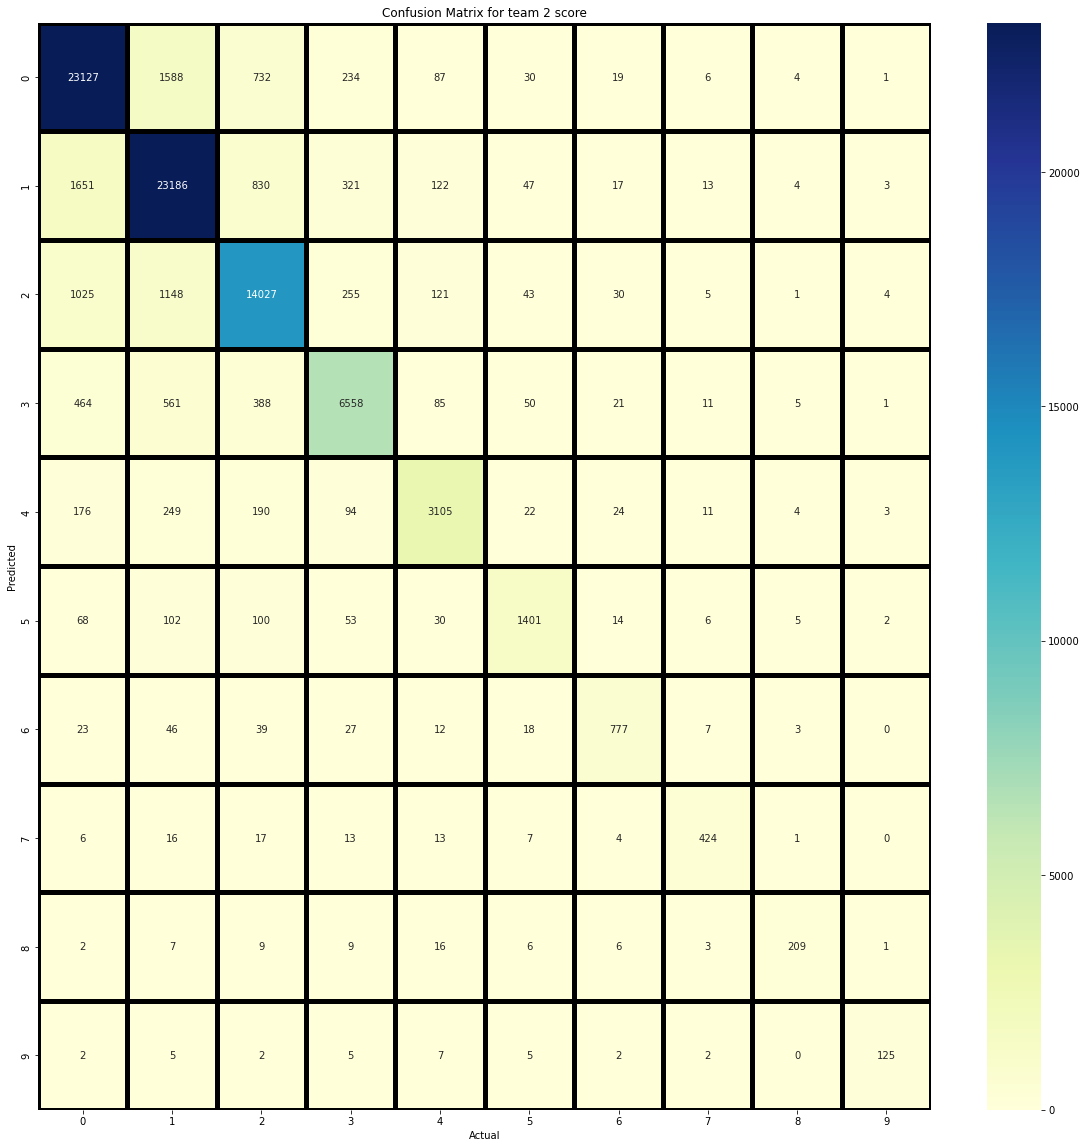

In [34]:
#Plotting the Confussion Matrix for score of Team 2

plt.figure(figsize = (20,20))
sns.heatmap(cm2, annot = True,fmt = "d", cmap='YlGnBu', linecolor = 'black', linewidths = 5)
plt.title("Confusion Matrix for team 2 score")
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [35]:
#Classification Report of team 2 Score

cr_report02 = classification_report(Y.iloc[:,1] , score_team_2)
print(cr_report02)

              precision    recall  f1-score   support

           0       0.87      0.90      0.88     25828
           1       0.86      0.89      0.87     26194
           2       0.86      0.84      0.85     16659
           3       0.87      0.81      0.83      8144
           4       0.86      0.80      0.83      3878
           5       0.86      0.79      0.82      1781
           6       0.85      0.82      0.83       952
           7       0.87      0.85      0.86       501
           8       0.89      0.78      0.83       268
           9       0.89      0.81      0.85       155

    accuracy                           0.86     84360
   macro avg       0.87      0.83      0.85     84360
weighted avg       0.86      0.86      0.86     84360



## Report 02 has a good accuracy in predicting the team 2 Score

In [36]:
#Defining a function to select the winning team for the prediction array

def select_winning_team(probability_array):
    probability_list = [round(probability_array[0][i],3) for i in range(2)]
    if (probability_list[0] > probability_list[1]):
        out = 0
    elif (probability_list[0] < probability_list[1]):
        out = 1
    elif (probability_list[0] == probability_list[1]):
        out = 2
    return out, probability_list

In [37]:
mactch_played=2015
team_1="Sri Lanka"
team_2="Brazil"
stadium="Qatar"

team_lst=[team_1,team_2]
team_1_num=label_encoder.transform([team_1])[0]
team_2_num=label_encoder.transform([team_2])[0]
stadium_num=label_encoder.transform([stadium])[0]

print(f"Team 01 is {team_1} -{team_1_num}")
print(f"Team 02 is {team_2} -{team_2_num}")
print(f"Played in  {stadium} -{stadium_num}")

Team 01 is Sri Lanka -279
Team 02 is Brazil -39
Played in  Qatar -235


In [38]:

X_feature=np.array([[mactch_played,stadium_num,team_1_num,team_2_num]])
res=model.predict(X_feature)
win,_=select_winning_team(res)
try:
    print(f"{team_1} vs {team_2} \n {team_lst[win]} wins 🏆⚽🎯\n")
except IndexError:
    print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽⚽\n") 

Sri Lanka vs Brazil 
  Match Draw ⚽⚽⚽



## FIFA WORLD CUP QATAR- 2022 

I have selected 32 teams that are going to participate in FIFA World Cup 2022. These teams are grouped based on the recent draws for the world cup 2022

Every team plays 3 matches in their respective groups. 

For each win, winning team gets +3 points

For each draw, both team gets +1 points

For each defeat, losing team gets +0 points

From the group, the top 2 teams advance to the Round of 16. Then, the knockouts begin. The teams would be drawn randomly and each team progresses to the next round as they win.

## FOR THE FIRST TIME, THE FIFA WORLD CUP IS TAKING PLACE IN NOVEMBER-DECEMBER
### SO BRACE YOURSELVES FOR THE MOST AWAITED COMPETITION IN THE WORLD
#### -----------------------------------------------------------------------------------------------------------------------------------
### HERE ARE THE GROUPS 

In [39]:
Group_A = ["Qatar","Ecuador","Senegal","Netherlands"]
Group_B = ["England","Iran","United States","Wales"]
Group_C = ["Argentina","Saudi Arabia","Mexico","Poland"]
Group_D = ["France","Peru","Denmark","Tunisia"]
Group_E = ["Spain","Costa Rica","Germany","Japan"]
Group_F = ["Belgium","Canada","Morocco","Croatia"]
Group_G = ["Brazil","Serbia","Switzerland","Cameroon"]
Group_H = ["Portugal","Ghana","Uruguay","South Korea"]
Groups ={"Group A":Group_A,"Group B":Group_B,"Group C":Group_C,"Group D":Group_D,"Group E":Group_E,"Group F":Group_F,"Group G":Group_G,"Group H":Group_H}

In [40]:
#Initialize basic parameters

year=2022
stadium = "Qatar"
stadium_num = label_encoder.transform([stadium])[0]
host_num = stadium_num

In [41]:
##Group stage Matches

Group_standings={}
for grp_name in list(Groups.keys()):
    print(f"{grp_name} Matches")
    probable_countries=Groups[grp_name]
    team_wins_dct={}
    goal_scored_dct={}
    goal_against_dct={}
    win_dct={}
    draw_dct={}
    lost_dct={}
    for i in range(len(probable_countries)):
        j=i+1
        team_1=probable_countries[i]
        team_1_num=label_encoder.transform([team_1])[0]
        team_wins=0
        while j<len((probable_countries)):
            team_2=probable_countries[j]
            team_2_num=label_encoder.transform([team_2])[0]
            team_lst=[team_1,team_2]
            Input_vector=np.array([[year,stadium_num,team_1_num,team_2_num]])
            res=model.predict(Input_vector)

            win,prob_lst=select_winning_team(res)
            goal_scored_dct[team_1] = goal_scored_dct.get(team_1,0)+prob_lst[0]
            goal_scored_dct[team_2] = goal_scored_dct.get(team_2,0)+prob_lst[1]

            goal_against_dct[team_1] = goal_against_dct.get(team_1,0)+prob_lst[1]
            goal_against_dct[team_2] = goal_against_dct.get(team_2,0)+prob_lst[0]

            try:
                print(f" {team_1} vs {team_2} \n  Results of the Match {res[0]}\n   {team_lst[win]} wins 🎊🏆⚽🎖️\n")
                if (win)==0:
                    team_wins_dct[team_1] = team_wins_dct.get(team_1,0)+3
                    team_wins_dct[team_2] = team_wins_dct.get(team_2,0)
                    
                    win_dct[team_1] = win_dct.get(team_1,0)+1
                    win_dct[team_2] = win_dct.get(team_2,0)
                    lost_dct[team_2] = lost_dct.get(team_2,0)+1
                    lost_dct[team_1] = lost_dct.get(team_1,0)
                    draw_dct[team_2] = draw_dct.get(team_2,0)
                    draw_dct[team_1] = draw_dct.get(team_1,0)

                elif (win)==1:
                    team_wins_dct[team_2] = team_wins_dct.get(team_2,0)+3
                    team_wins_dct[team_1] = team_wins_dct.get(team_1,0)
                    
                    win_dct[team_2] = win_dct.get(team_2,0)+1
                    win_dct[team_1] = win_dct.get(team_1,0)
                    lost_dct[team_1] = lost_dct.get(team_1,0)+1
                    lost_dct[team_2] = lost_dct.get(team_2,0)
                    draw_dct[team_1] = draw_dct.get(team_1,0)
                    draw_dct[team_2] = draw_dct.get(team_2,0)

            except IndexError:
                print(f"{team_1} vs {team_2} \n  Results of the Match {res[0]}\n   Match Draw ⚽⚽⚽\n") 
                team_wins_dct[team_1] = team_wins_dct.get(team_1,0)+1
                team_wins_dct[team_2] = team_wins_dct.get(team_2,0)+1
                
                draw_dct[team_1] = draw_dct.get(team_1,0)+1
                draw_dct[team_2] = draw_dct.get(team_2,0)+1
                
                win_dct[team_1] = win_dct.get(team_1,0)
                lost_dct[team_1] = lost_dct.get(team_1,0)
                
                win_dct[team_2] = win_dct.get(team_2,0)
                lost_dct[team_2] = lost_dct.get(team_2,0)
                    
            j=j+1
    group_results=[win_dct,draw_dct,lost_dct,team_wins_dct,goal_scored_dct,goal_against_dct]
    Group_standings[grp_name]=group_results

Group A Matches
Qatar vs Ecuador 
  Results of the Match [1 1]
   Match Draw ⚽⚽⚽

Qatar vs Senegal 
  Results of the Match [1 1]
   Match Draw ⚽⚽⚽

Qatar vs Netherlands 
  Results of the Match [1 1]
   Match Draw ⚽⚽⚽

 Ecuador vs Senegal 
  Results of the Match [0 1]
   Senegal wins 🎊🏆⚽🎖️

 Ecuador vs Netherlands 
  Results of the Match [0 1]
   Netherlands wins 🎊🏆⚽🎖️

Senegal vs Netherlands 
  Results of the Match [2 2]
   Match Draw ⚽⚽⚽

Group B Matches
England vs Iran 
  Results of the Match [1 1]
   Match Draw ⚽⚽⚽

England vs United States 
  Results of the Match [0 0]
   Match Draw ⚽⚽⚽

 England vs Wales 
  Results of the Match [3 0]
   England wins 🎊🏆⚽🎖️

Iran vs United States 
  Results of the Match [1 1]
   Match Draw ⚽⚽⚽

 Iran vs Wales 
  Results of the Match [1 0]
   Iran wins 🎊🏆⚽🎖️

United States vs Wales 
  Results of the Match [0 0]
   Match Draw ⚽⚽⚽

Group C Matches
 Argentina vs Saudi Arabia 
  Results of the Match [1 0]
   Argentina wins 🎊🏆⚽🎖️

 Argentina vs Mexico 
  

## Group stage results

In [42]:
for grp_name in list(Group_standings.keys()):

    team_wins_dct= dict(sorted(Group_standings[grp_name][3].items()))
    goal_scored_dct=dict(sorted(Group_standings[grp_name][4].items()))
    goal_against_dct=dict(sorted(Group_standings[grp_name][5].items()))
    
    win_dct=dict(sorted(Group_standings[grp_name][0].items()))
    draw_dct=dict(sorted(Group_standings[grp_name][1].items()))
    lost_dct=dict(sorted(Group_standings[grp_name][2].items()))
    
    lst_teams=list(team_wins_dct.keys())
    
    win_lst=list(win_dct.values())
    draw_lst=list(draw_dct.values())
    lost_lst=list(lost_dct.values())
    
    lst_win_count=list(team_wins_dct.values())
    goal_scored=list(goal_scored_dct.values())
    goal_against=list(goal_against_dct.values())
    goal_differance=[goal_scored[i]-goal_against[i] for i in range (len(goal_scored))]
    ranking_table=pd.DataFrame(list(zip(lst_teams,win_lst,draw_lst,lost_lst,goal_scored,goal_against,goal_differance,lst_win_count)),columns=["Team","Wins","Draw","Lost","Goal Scored","Goal Against","Goal Differance","Points"])
    ranking_table=ranking_table.sort_values("Points",ascending=False).reset_index(drop=True)
    ranking_table.index = ranking_table.index + 1
    print(f"\n\n{grp_name} Final Rankings")
    print(ranking_table.to_markdown())



Group A Final Rankings
|    | Team        |   Wins |   Draw |   Lost |   Goal Scored |   Goal Against |   Goal Differance |   Points |
|---:|:------------|-------:|-------:|-------:|--------------:|---------------:|------------------:|---------:|
|  1 | Netherlands |      1 |      2 |      0 |             4 |              3 |                 1 |        5 |
|  2 | Senegal     |      1 |      2 |      0 |             4 |              3 |                 1 |        5 |
|  3 | Qatar       |      0 |      3 |      0 |             3 |              3 |                 0 |        3 |
|  4 | Ecuador     |      0 |      1 |      2 |             1 |              3 |                -2 |        1 |


Group B Final Rankings
|    | Team          |   Wins |   Draw |   Lost |   Goal Scored |   Goal Against |   Goal Differance |   Points |
|---:|:--------------|-------:|-------:|-------:|--------------:|---------------:|------------------:|---------:|
|  1 | England       |      1 |      2 |      0 | 

## ROUND OF 16 RESULTS

In [43]:
qualified_teams_1=[]
standings=list(Group_standings.keys())
i=0
print(f"Round of 16\n")
while i < (len(standings)):
    A_team= sorted(Group_standings[standings[i]][3].items(), key=lambda x: x[1], reverse=True)
    team_1=A_team[0][0]
    B_team= sorted(Group_standings[standings[i+1]][3].items(), key=lambda x: x[1], reverse=True)
    team_2=B_team[1][0]
    
    team_1_num=label_encoder.transform([team_1])[0]
    team_2_num=label_encoder.transform([team_2])[0]
    team_lst=[team_1,team_2]
    
    Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
    res=model.predict(Input_vector)
    win,_=select_winning_team(res)

    try:
            print(f"{team_1} vs {team_2} \n  {team_lst[win]} wins 🏆🏆")
            print(f"    {team_lst[win]} into the Quater-Finals ⏩⏩ \n")
            qualified_teams_1.append(team_lst[win])
    except IndexError:
            print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
            winning_team=random.choice(team_lst)
            print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
            print(f"    {winning_team} into the Quater-Finals ⏩⏩ \n")
            qualified_teams_1.append(winning_team)
    i=i+2
    
##Round of 16 Section_2
qualified_teams_2=[]
standings=list(Group_standings.keys())
i=0
while i < (len(standings)):
    A_team= sorted(Group_standings[standings[i]][3].items(), key=lambda x: x[1], reverse=True)
    team_1=A_team[1][0]
    B_team= sorted(Group_standings[standings[i+1]][3].items(), key=lambda x: x[1], reverse=True)
    team_2=B_team[0][0]
    
    team_1_num=label_encoder.transform([team_1])[0]
    team_2_num=label_encoder.transform([team_2])[0]
    team_lst=[team_1,team_2]
    
    Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
    res=model.predict(Input_vector)
    win,_=select_winning_team(res)

    try:
            print(f"{team_1} vs {team_2} \n  {team_lst[win]} wins 🏆🏆")
            print(f"    {team_lst[win]} into the Quater-Finals ⏩⏩ \n")
            qualified_teams_2.append(team_lst[win])
            
    except IndexError:
            print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
            winning_team=random.choice(team_lst)
            print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
            print(f"    {winning_team} into the Quater-Finals ⏩⏩ \n")
            qualified_teams_2.append(winning_team)
    i=i+2

Round of 16

Senegal vs Iran 
  Match Draw ⚽⚽
   Iran wins at Penaly Shoot-Out 🥅🎯
    Iran into the Quater-Finals ⏩⏩ 

Poland vs Peru 
  Match Draw ⚽⚽
   Peru wins at Penaly Shoot-Out 🥅🎯
    Peru into the Quater-Finals ⏩⏩ 

Japan vs Croatia 
  Japan wins 🏆🏆
    Japan into the Quater-Finals ⏩⏩ 

Brazil vs Uruguay 
  Match Draw ⚽⚽
   Brazil wins at Penaly Shoot-Out 🥅🎯
    Brazil into the Quater-Finals ⏩⏩ 

Netherlands vs England 
  England wins 🏆🏆
    England into the Quater-Finals ⏩⏩ 

Argentina vs Denmark 
  Match Draw ⚽⚽
   Argentina wins at Penaly Shoot-Out 🥅🎯
    Argentina into the Quater-Finals ⏩⏩ 

Germany vs Belgium 
  Belgium wins 🏆🏆
    Belgium into the Quater-Finals ⏩⏩ 

Serbia vs Portugal 
  Match Draw ⚽⚽
   Portugal wins at Penaly Shoot-Out 🥅🎯
    Portugal into the Quater-Finals ⏩⏩ 



In [44]:
print(f"Teams selected to the Quater Finals - {qualified_teams_1+qualified_teams_2}")

Teams selected to the Quater Finals - ['Iran', 'Peru', 'Japan', 'Brazil', 'England', 'Argentina', 'Belgium', 'Portugal']


## QUARTER FINAL RESULTS

In [45]:
Semifinal_teams=[]
i=0
print(f"Quater Final Matches\n")
while i < (len(qualified_teams_1))-1:
    team_1= qualified_teams_1[i]
    team_2= qualified_teams_1[i+1]
    
    team_1_num=label_encoder.transform([team_1])[0]
    team_2_num=label_encoder.transform([team_2])[0]
    team_lst=[team_1,team_2]
    
    Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
    res=model.predict(Input_vector)
    win,_=select_winning_team(res)

    try:
            print(f"{team_1} vs {team_2} \n  {team_lst[win]} wins 🏆🏆")
            print(f"    {team_lst[win]} into the Semi-Finals ⏩⏩ \n")
            Semifinal_teams.append(team_lst[win])
            
    except IndexError:
            print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽")
            winning_team=random.choice(team_lst)
            print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
            print(f"    {winning_team} into the Semi-Finals ⏩⏩ \n")
            Semifinal_teams.append(winning_team)
    i=i+2
    
i=0
while i < (len(qualified_teams_2))-1:
    team_1= qualified_teams_2[i]
    team_2= qualified_teams_2[i+1]
    team_1_num=label_encoder.transform([team_1])[0]
    team_2_num=label_encoder.transform([team_2])[0]
    team_lst=[team_1,team_2]
    
    Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
    res=model.predict(Input_vector)
    win,_=select_winning_team(res)

    try:
            print(f"{team_1} vs {team_2} \n  {team_lst[win]} wins 🏆🏆")
            print(f"    {team_lst[win]} into the Semi-Finals ⏩⏩ \n")
            Semifinal_teams.append(team_lst[win])
            
    except IndexError:
            print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
            winning_team=random.choice(team_lst)
            print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
            print(f"    {winning_team} into the Semi-Finals ⏩⏩ \n")
            Semifinal_teams.append(winning_team)
    i=i+2

Quater Final Matches

Iran vs Peru 
  Iran wins 🏆🏆
    Iran into the Semi-Finals ⏩⏩ 

Japan vs Brazil 
  Brazil wins 🏆🏆
    Brazil into the Semi-Finals ⏩⏩ 

England vs Argentina 
  Match Draw ⚽⚽
   Argentina wins at Penaly Shoot-Out 🥅🎯
    Argentina into the Semi-Finals ⏩⏩ 

Belgium vs Portugal 
  Belgium wins 🏆🏆
    Belgium into the Semi-Finals ⏩⏩ 



In [46]:
print(f"Teams selected to the Semi-Finals - {Semifinal_teams}")

Teams selected to the Semi-Finals - ['Iran', 'Brazil', 'Argentina', 'Belgium']


## SEMI FINAL RESULTS

In [47]:
final_teams=[]
third_place_match_teams=[]
i=0
print(f"Semi Final Matches\n")
while i < (len(Semifinal_teams))-1:
    team_1= Semifinal_teams[i]
    team_2= Semifinal_teams[i+1]
    
    team_1_num=label_encoder.transform([team_1])[0]
    team_2_num=label_encoder.transform([team_2])[0]
    team_lst=[team_1,team_2]
    
    Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
    res=model.predict(Input_vector)
    win,_=select_winning_team(res)

    try:
            print(f"{team_1} vs {team_2} \n  {team_lst[win]} wins 🏆🏆")
            print(f"    {team_lst[win]} into the FIFA-Finals ⏩⏩ \n")
            final_teams.append(team_lst[win])
            third_place_match_teams.append(team_lst[(win+1)%2])

            
    except IndexError:
            print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
            winning_team=random.choice(team_lst)
            print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
            print(f"    {winning_team} into the FIFA-Finals ⏩⏩ \n")
            final_teams.append(winning_team)
            team_lst.remove(winning_team)
            third_place_match_teams.append(team_lst[0])
    i=i+2

Semi Final Matches

Iran vs Brazil 
  Brazil wins 🏆🏆
    Brazil into the FIFA-Finals ⏩⏩ 

Argentina vs Belgium 
  Argentina wins 🏆🏆
    Argentina into the FIFA-Finals ⏩⏩ 



In [48]:
print(f"Teams selected to the Finals - {final_teams}")
print(f"Teams selected to the Third Place match - {third_place_match_teams}")

Teams selected to the Finals - ['Brazil', 'Argentina']
Teams selected to the Third Place match - ['Iran', 'Belgium']


## THIRD PLACE RESULTS

In [49]:
print(f"FIFA FINAL\n")
print('-------------')
team_1= final_teams[1]
team_2= final_teams[0]
    
team_1_num=label_encoder.transform([team_1])[0]
team_2_num=label_encoder.transform([team_2])[0]
team_lst=[team_1,team_2]
    
Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
res=model.predict(Input_vector)
win,_=select_winning_team(res)

try:
    print(f"{team_1} vs {team_2} \n  {team_lst[win]} are the Winners of the FIFA WORLD CUP 2022 🎉🏆🎉\n\n")
    winner=team_lst[win]
    place_2=team_lst[(win+1)%2]
            
except IndexError:
    print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
    winning_team=random.choice(team_lst)
    print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
    print(f"    {winning_team} are the Winners 🎉🏆🎉\n\n")
    winner=winning_team
    
    team_lst.remove(winning_team)
    place_2=team_lst[0]

print(f"Third Place match\n")
team_1= third_place_match_teams[1]
team_2= third_place_match_teams[0]
    
team_1_num=label_encoder.transform([team_1])[0]
team_2_num=label_encoder.transform([team_2])[0]
team_lst=[team_1,team_2]
    
Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
res=model.predict(Input_vector)
win,_=select_winning_team(res)

try:
    print(f"{team_1} vs {team_2} \n  {team_lst[win]} Wins the 3rd Place 🎉🏆🎉\n")
    place_3=team_lst[win]
            
except IndexError:
    print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
    winning_team=random.choice(team_lst)
    print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
    print(f"    {winning_team} Wins the 3rd Place 🎉🏆🎉\n")
    place_3=winning_team
    
print(f"Runner-up is {place_2} 🥈🥈🥈")
print(f"3rd Place is {place_3} 🥉🥉🥉")

FIFA FINAL

-------------
Argentina vs Brazil 
  Argentina are the Winners of the FIFA WORLD CUP 2022 🎉🏆🎉


Third Place match

Belgium vs Iran 
  Iran Wins the 3rd Place 🎉🏆🎉

Runner-up is Brazil 🥈🥈🥈
3rd Place is Iran 🥉🥉🥉


## AND THE WINNER OF THE FIFA WORLD CUP IS.......

In [50]:
print(f"\n\nWinner is {winner} 🥇🥇🥇")



Winner is Argentina 🥇🥇🥇
